# Oil Spill Detection using DeepLabV3+ model with ResNet101 backbone

## Compress Images

In [ ]:
import os
import cv2

INPUT_IMAGE_DIR = "dataset/train/compressed_images/"

OUTPUT_IMAGE_DIR = "dataset/train/images/"
TARGET_SIZE = (320, 320)
JPEG_QUALITY = 50

os.makedirs(OUTPUT_IMAGE_DIR, exist_ok=True)

for filename in os.listdir(INPUT_IMAGE_DIR):
    img_path = os.path.join(INPUT_IMAGE_DIR, filename)
    output_path = os.path.join(OUTPUT_IMAGE_DIR, filename)

    img = cv2.imread(img_path)
    if img is not None:
        resized_img = cv2.resize(img, TARGET_SIZE, interpolation=cv2.INTER_AREA)
        cv2.imwrite(output_path, resized_img, [cv2.IMWRITE_JPEG_QUALITY, JPEG_QUALITY])
        print(f"Compressed: {filename}")

print("All images resized and compressed successfully!")

## Importing the required libraries

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from torchvision.models.segmentation import deeplabv3_resnet101, DeepLabV3_ResNet101_Weights
from torchvision.models.segmentation.deeplabv3 import DeepLabHead
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

## Defining the dataset class

In [ ]:
class OilSpillDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]
        self.masks = [f.replace('.jpg', '.png') for f in self.images]
        
        # RGB to class index mapping
        self.color_to_class = {
            (0, 0, 0): 0,      # Background
            (255, 0, 124): 1,  # Oil
            (255, 204, 51): 2, # Others
            (51, 221, 255): 3  # Water
        }

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        mask_name = self.masks[idx]
        image_path = os.path.join(self.image_dir, img_name)
        mask_path = os.path.join(self.mask_dir, mask_name)

        image = Image.open(image_path).convert('RGB')
        mask = Image.open(mask_path).convert('RGB')

        # Converting RGB mask to class indices
        mask_np = np.array(mask)
        mask_indices = np.zeros((mask_np.shape[0], mask_np.shape[1]), dtype=np.uint8)
        for color, class_idx in self.color_to_class.items():
            mask_indices[np.all(mask_np == color, axis=-1)] = class_idx
        
        mask = torch.from_numpy(mask_indices).long()

        if self.transform:
            image = self.transform(image)

        return image, mask

## Transformations for images only

In [12]:
image_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

## Datasets

In [13]:
train_dataset = OilSpillDataset('dataset/train/images', 'dataset/train/masks', transform=image_transform)
val_dataset = OilSpillDataset('dataset/val/images', 'dataset/val/masks', transform=image_transform)
test_dataset = OilSpillDataset('dataset/test/images', 'dataset/test/masks', transform=image_transform)

## Data Loaders

In [14]:
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

## Loading the pre-trained DeepLabV3+ model with ResNet101 backbone

In [6]:
model = deeplabv3_resnet101(weights=DeepLabV3_ResNet101_Weights.DEFAULT)

## Modify the classifier to output 4 classes
### 4 classes: background, oil, others, water

In [ ]:
model.classifier = DeepLabHead(2048, 4)  

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

## Define loss function and optimizer

In [ ]:
class_weights = torch.tensor([0.1, 10.0, 0.5, 0.5], dtype=torch.float).to(device)  # Higher weight for oil
criterion = nn.CrossEntropyLoss(weight=class_weights)

optimizer = optim.Adam(model.parameters(), lr=0.001)

## Training

In [ ]:
# Training Function
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=7):
    train_losses = []
    val_losses = []
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, masks in train_loader:
            images, masks = images.to(device), masks.to(device)
            optimizer.zero_grad()
            outputs = model(images)['out']
            loss = criterion(outputs, masks) 
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)
        print(f'Epoch {epoch+1}, Train Loss: {train_loss}')

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.to(device), masks.to(device)
                outputs = model(images)['out']
                loss = criterion(outputs, masks)
                val_loss += loss.item()

        val_loss_avg = val_loss / len(val_loader)
        val_losses.append(val_loss_avg)
        print(f'Epoch {epoch+1}, Val Loss: {val_loss_avg}')

    return train_losses, val_losses

# Train the Model
print("Starting training...")
train_losses, val_losses = train_model(model, criterion, optimizer, train_loader, val_loader)

# Save the Model
torch.save(model.state_dict(), 'deeplabv3_resnet101_oil_spill.pth')
print("Model saved as 'deeplabv3_resnet101_oil_spill.pth'")

Starting training...
Epoch 1, Train Loss: 0.6138811162114144
Epoch 1, Val Loss: 4.686293269246817
Epoch 2, Train Loss: 0.595262906551361
Epoch 2, Val Loss: 0.9664043943583965
Epoch 3, Train Loss: 0.48885194942355154
Epoch 3, Val Loss: 0.6410875123739243
Epoch 4, Train Loss: 0.47242163226008416
Epoch 4, Val Loss: 0.8631341806054116
Epoch 5, Train Loss: 0.3373896145820618
Epoch 5, Val Loss: 1.6297760682553053
Epoch 6, Train Loss: 0.44327830359339715
Epoch 6, Val Loss: 0.6518757484853268
Epoch 7, Train Loss: 0.3577146831154823
Epoch 7, Val Loss: 1.0814018728584052
Model saved as 'deeplabv3_resnet101_oil_spill.pth'


## Plot training and validation loss

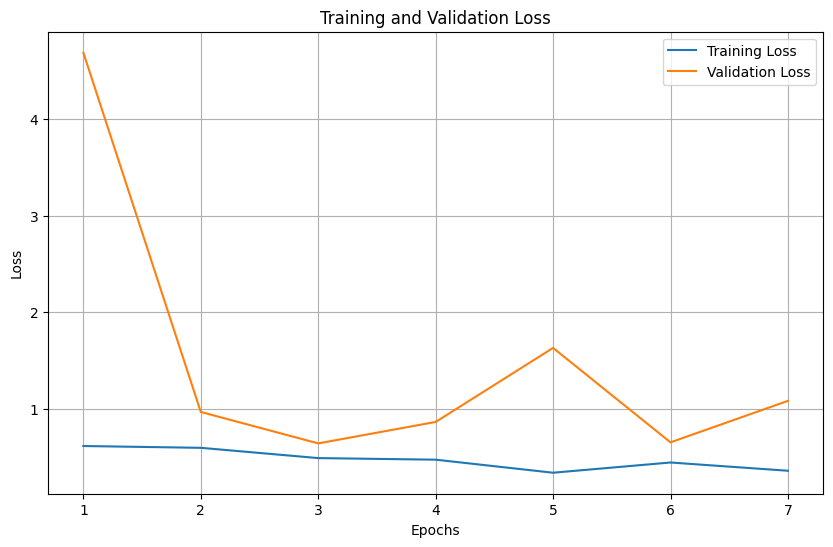

In [ ]:
train_losses = [
    0.6138811162114144,
    0.595262906551361,
    0.48885194942355154,
    0.47242163226008416,
    0.3373896145820618,
    0.44327830359339715,
    0.3577146831154823
]

val_losses = [
    4.686293269246817,
    0.9664043943583965,
    0.6410875123739243,
    0.8631341806054116,
    1.6297760682553053,
    0.6518757484853268,
    1.0814018728584052
]

epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

## Evaluating the model on test dataset

In [ ]:
def test_model(model, test_loader):
    model.eval()
    total_pixels = 0
    correct_pixels = 0
    
    with torch.no_grad():
        for images, masks in test_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)['out'] 
            _, predicted = torch.max(outputs, dim=1) 
            
            # Calculate accuracy
            total_pixels += masks.numel() 
            correct_pixels += (predicted == masks).sum().item() 
    
    accuracy = 100 * correct_pixels / total_pixels
    print(f"Test Accuracy: {accuracy:.2f}% (Correct: {correct_pixels}, Total: {total_pixels})")
    
    return accuracy

print("Starting testing on test dataset...")
test_accuracy = test_model(model, test_loader)

Starting testing on test dataset...
Test Accuracy: 69.73% (Correct: 14280485, Total: 20480000)


In [ ]:
# Defining the model with auxiliary classifier
model = deeplabv3_resnet101(weights=None, aux_loss=True)
model.classifier = DeepLabHead(2048, 4)

# Loading the saved state dictionary
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.load_state_dict(torch.load('deeplabv3_resnet101_oil_spill.pth', map_location=device))
model = model.to(device)
model.eval()

## Confusion Matrix

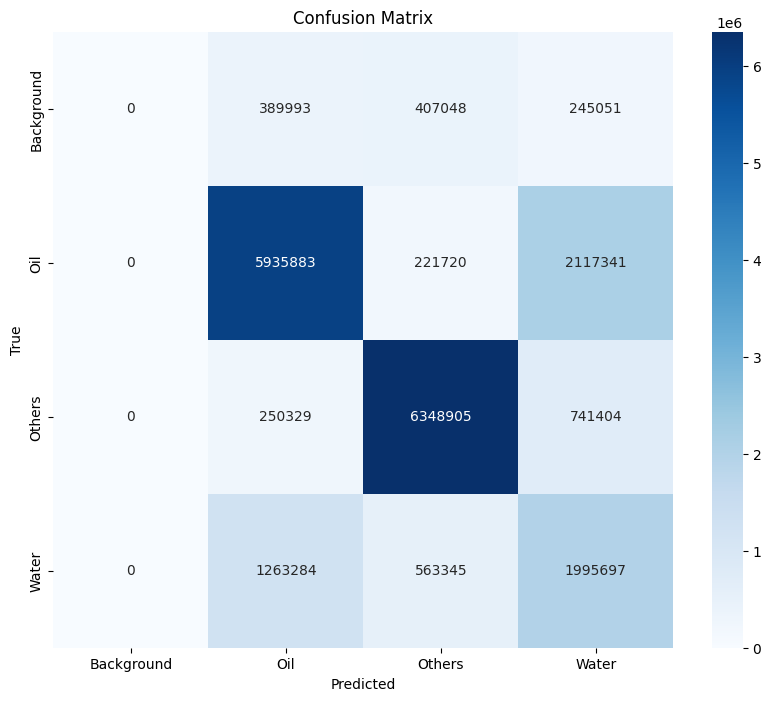

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

true_masks = []
predicted_masks = []

with torch.no_grad():
    for images, masks in test_loader:
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs['out'], dim=1)
        true_masks.extend(masks.cpu().numpy().flatten())
        predicted_masks.extend(predicted.cpu().numpy().flatten())

def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

classes = ['Background', 'Oil', 'Others', 'Water']
plot_confusion_matrix(true_masks, predicted_masks, classes)

## ROC Curves

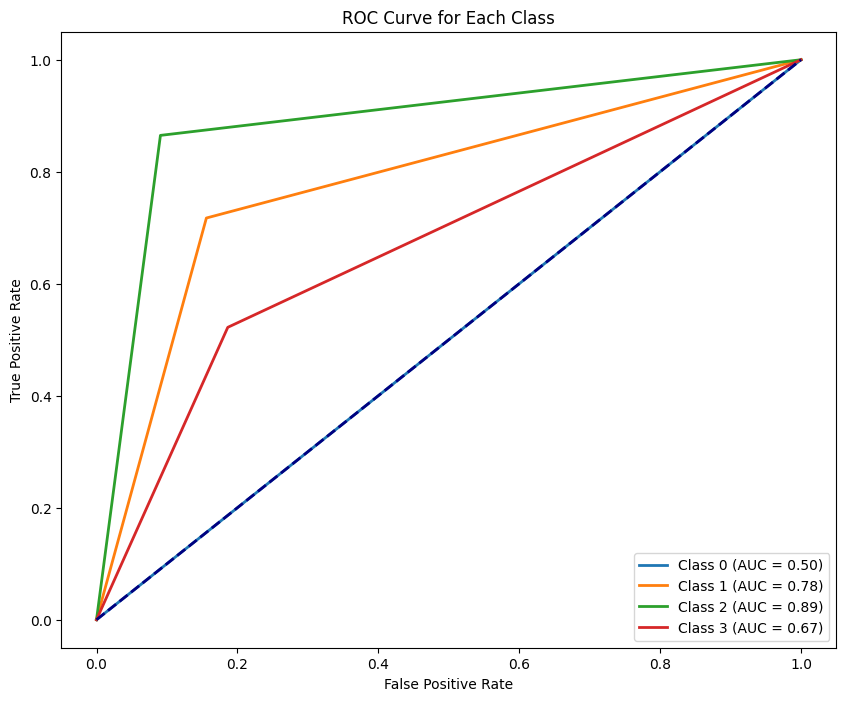

In [ ]:
from sklearn.metrics import roc_curve, auc

# Converting masks to binary labels for each class
num_classes = 4
y_true = np.zeros((len(true_masks), num_classes))
y_pred = np.zeros((len(predicted_masks), num_classes))

for i in range(len(true_masks)):
    for class_idx in range(num_classes):
        y_true[i, class_idx] = (true_masks[i] == class_idx).astype(int)
        y_pred[i, class_idx] = (predicted_masks[i] == class_idx).astype(int)

# Plotting ROC curve for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Each Class")
plt.legend(loc="lower right")
plt.show()

## Precision Recall Curves

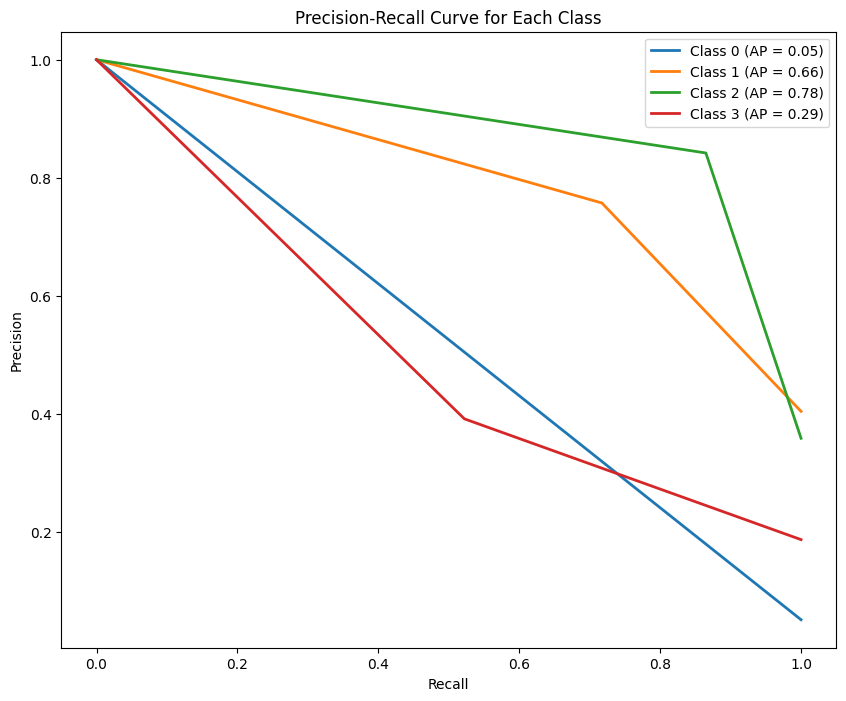

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score

precision = dict()
recall = dict()
average_precision = dict()

for i in range(num_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_true[:, i], y_pred[:, i])
    average_precision[i] = average_precision_score(y_true[:, i], y_pred[:, i])

plt.figure(figsize=(10, 8))
for i in range(num_classes):
    plt.plot(recall[i], precision[i], lw=2,
             label=f'Class {i} (AP = {average_precision[i]:.2f})')

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve for Each Class")
plt.legend(loc="best")
plt.show()

## IOU Scores

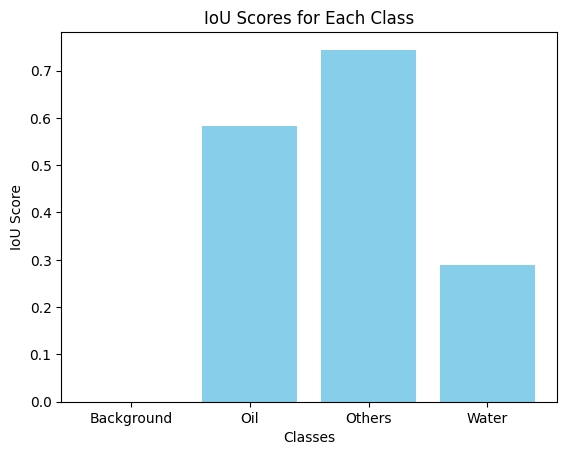

In [ ]:
from sklearn.metrics import jaccard_score

iou_scores = []
for i in range(num_classes):
    iou_scores.append(jaccard_score(y_true[:, i], y_pred[:, i], average='binary'))

plt.bar(classes, iou_scores, color='skyblue')
plt.title('IoU Scores for Each Class')
plt.xlabel('Classes')
plt.ylabel('IoU Score')
plt.show()

## Class-wise Accuracy

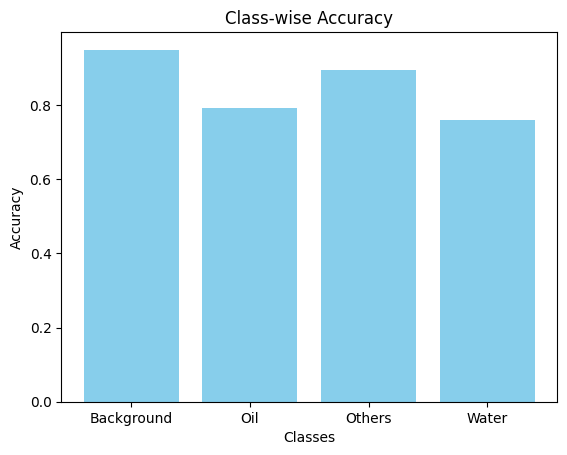

In [ ]:
from sklearn.metrics import accuracy_score

class_accuracy = []
for i in range(num_classes):
    class_accuracy.append(accuracy_score(y_true[:, i], y_pred[:, i]))

classes = ['Background', 'Oil', 'Others', 'Water']
plt.bar(classes, class_accuracy, color='skyblue')
plt.title('Class-wise Accuracy')
plt.xlabel('Classes')
plt.ylabel('Accuracy')
plt.show()

## Summary of keys and tensors in saved model dictionary

In [ ]:
import torch

# Load the saved state dictionary
model_path = "deeplabv3_resnet101_oil_spill.pth"
state_dict = torch.load(model_path, map_location="cpu")

# Print summary of keys and tensor shapes
for key, value in state_dict.items():
    print(f"{key}: {value.shape}")

In [ ]:
print(model)

In [ ]:
import torch
import torch.nn as nn
from collections import OrderedDict

def summary(model, input_size, batch_size=-1, device="cuda"):
    def register_hook(module):
        def hook(module, input, output):
            class_name = str(module.__class__).split(".")[-1].split("'")[0]
            module_idx = len(summary)

            m_key = "%s-%i" % (class_name, module_idx + 1)
            summary[m_key] = OrderedDict()
            summary[m_key]["input_shape"] = list(input[0].size())
            summary[m_key]["input_shape"][0] = batch_size

            if isinstance(output, (OrderedDict, dict)):
                summary[m_key]["output_shape"] = {k: list(o.size()) for k, o in output.items()}
            else:
                summary[m_key]["output_shape"] = list(output.size())
                summary[m_key]["output_shape"][0] = batch_size

            params = 0
            if hasattr(module, "weight"):
                params += torch.numel(module.weight)
                summary[m_key]["trainable"] = module.weight.requires_grad
            if hasattr(module, "bias") and module.bias is not None:
                params += torch.numel(module.bias)
                summary[m_key]["trainable"] += module.bias.requires_grad
            summary[m_key]["nb_params"] = params

        if (
            not isinstance(module, nn.Sequential)
            and not isinstance(module, nn.ModuleList)
            and not (module == model)
        ):
            hooks.append(module.register_forward_hook(hook))

    device = device.lower()
    assert device in [
        "cuda",
        "cpu",
    ], "Input device is not valid, please specify 'cuda' or 'cpu'"

    if device == "cuda" and torch.cuda.is_available():
        dtype = torch.cuda.FloatTensor
    else:
        dtype = torch.FloatTensor

    # multiple inputs to the network
    if isinstance(input_size, tuple):
        input_size = [input_size]
    x = [torch.rand(2, *in_size).type(dtype) for in_size in input_size]
    # print(type(x[0]))

    # create properties
    summary = OrderedDict()
    hooks = []

    # register hook
    model.apply(register_hook)

    # make a forward pass
    model(*x)

    # remove these hooks
    for h in hooks:
        h.remove()

    print("----------------------------------------------------------------")
    line_new = "{:>20}  {:>25} {:>15}".format("Layer (type)", "Output Shape", "Param #")
    print(line_new)
    print("================================================================")
    total_params = 0
    trainable_params = 0
    for layer in summary:
        # input_shape, output_shape, trainable, nb_params
        line_new = "{:>20}  {:>25} {:>15}".format(
            layer,
            str(summary[layer]["output_shape"]),
            "{0:,}".format(summary[layer]["nb_params"]),
        )
        total_params += summary[layer]["nb_params"]
        if "trainable" in summary[layer]:
            if summary[layer]["trainable"] == True:
                trainable_params += summary[layer]["nb_params"]
        print(line_new)

    print("================================================================")
    print("Total params: {0:,}".format(total_params))
    print("Trainable params: {0:,}".format(trainable_params))
    print("Non-trainable params: {0:,}".format(total_params - trainable_params))
    print("----------------------------------------------------------------")
    return summary

# Example usage
model = models.deeplabv3_resnet101(weights=None, aux_loss=True)
model.classifier = DeepLabHead(2048, 4)
model.load_state_dict(torch.load('deeplabv3_resnet101_oil_spill.pth', map_location=device))
model = model.to(device)
model.eval()

summary(model, input_size=(3, 320, 320), batch_size=2, device="cuda")

## Live Testing

In [3]:
import gradio as gr
# Gradio Prediction Function
def predict_oil_spill(image):
    model.eval()
    image = image.resize((320, 320))
    input_tensor = image_transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_tensor)['out']
        pred_mask = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()

    total_pixels = pred_mask.size
    oil_pixels = np.sum(pred_mask == 1)
    oil_percentage = (oil_pixels / total_pixels) * 100

    color_map = {0: [0, 0, 0], 1: [255, 0, 124], 2: [255, 204, 51], 3: [51, 221, 255]}
    pred_mask_rgb = np.zeros((320, 320, 3), dtype=np.uint8)
    for class_idx, color in color_map.items():
        pred_mask_rgb[pred_mask == class_idx] = color

    return pred_mask_rgb, f"Oil Spill Detected: {oil_percentage:.2f}%"

# Gradio Interface
interface = gr.Interface(
    fn=predict_oil_spill,
    inputs=gr.Image(type="pil", label="Upload an Image"),
    outputs=[
        gr.Image(type="numpy", label="Predicted Mask"),
        gr.Textbox(label="Oil Detection Result")
    ],
    title="Oil Spill Detection",
    description="Upload an image to detect oil spills using a trained DeepLabV3+ model."
)

# Launch Gradio Interface
interface.launch(share=True)

ModuleNotFoundError: No module named 'huggingface_hub'